In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Cargo el Dataset del M. Salud de la Nación http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina

In [3]:
datos = pd.read_csv("Covid19Casos.csv", parse_dates = [8,9,11,13,15,22,24])

Me quedo con los positivos

In [4]:
positivos = datos[datos["clasificacion_resumen"] == "Confirmado"]

Defino funciones pare calcular casos por día, promedio de 7 días y casos entre 2 fechas cualesquiera, por provincia y edad

In [5]:
def casos_dia(provincia,dia,edadmin = None, edadmax = None):
	if edadmin is None and edadmax is None:
		casos = positivos[(positivos["residencia_provincia_nombre"] == provincia) & (positivos["fecha_diagnostico"] == dia)].id_evento_caso.count()
	else:
		casos = positivos[(positivos["residencia_provincia_nombre"] == provincia) & ((positivos["fecha_diagnostico"] == dia) & ((positivos["edad"] >= edadmin) & (positivos["edad"] < edadmax)))].id_evento_caso.count()
	return casos

In [6]:
def casos_dia_promedio(provincia,dia,edadmin = None, edadmax = None):
	inicio = dia - pd.Timedelta("3 d")
	fin = dia  + pd.Timedelta("4 d")
	if edadmin is None and edadmax is None:
		casos = positivos[(positivos["residencia_provincia_nombre"] == provincia) & ((positivos["fecha_diagnostico"] >= inicio) & (positivos["fecha_diagnostico"] < fin))].id_evento_caso.count()/7
	else:
		casos = positivos[(positivos["residencia_provincia_nombre"] == provincia) & ((positivos["fecha_diagnostico"] >= inicio) & (positivos["fecha_diagnostico"] < fin)) & ((positivos["edad"] >= edadmin) & (positivos["edad"] < edadmax))].id_evento_caso.count()/7
	return casos

In [7]:
def casos_entre(provincia,inicio,fin,edadmin = None, edadmax = None):
    if edadmin is None and edadmax is None:
	    casos = positivos[(positivos["residencia_provincia_nombre"] == provincia) & ((positivos["fecha_diagnostico"] >= inicio) & (positivos["fecha_diagnostico"] < fin))].id_evento_caso.count()
    else:
	    casos = positivos[(positivos["residencia_provincia_nombre"] == provincia) & ((positivos["fecha_diagnostico"] >= inicio) & (positivos["fecha_diagnostico"] < fin)) & ((positivos["edad"] >= edadmin) & (positivos["edad"] < edadmax))].id_evento_caso.count()
    return casos

Calculo casos diarios desde el incio de la pandemia. Totales y por edades escolares

In [8]:
dias = pd.date_range("20200316","20210412",freq="D")
provincia = "CABA"
niveles = {'Inicial':[0,6,],'Primaria':[6,13],'Secundaria':[13,19],'Adultxs':[19,100]}

# ESTO LLEVA MUCHO TIEMPO Y NO LO ESTOY USANDO
#casos_diarios = []
#for niv in niveles:
#    casos_franja = []
#    for dia in dias:
#        casos_franja.append(casos_dia(provincia,dia,niveles[niv][0],niveles[niv][1]))
#    casos_diarios.append(casos_franja)

casos_diarios_totales = []
for dia in dias:
    casos_diarios_totales.append(casos_dia(provincia,dia))

Promedio 7 días

In [9]:
casos_dia_prom = []
for niv in niveles:
    casos_franja = []
    for dia in dias:
        casos_franja.append(casos_dia_promedio(provincia,dia,niveles[niv][0],niveles[niv][1]))
    casos_dia_prom.append(casos_franja)

casos_dia_prom_totales = []
for dia in dias:
    casos_dia_prom_totales.append(casos_dia_promedio(provincia,dia))

Calculo los maximos alcanzados en cada ola

In [10]:
fin_ola = [dias.get_loc(pd.to_datetime("20201101")),dias.get_loc(pd.to_datetime("20210301")),dias.get_loc(pd.to_datetime("20210412"))]

maximos = []
for fin in fin_ola:
    ymax = max(casos_diarios_totales[:fin])
    xmax = casos_diarios_totales.index(ymax)
    maximos.append((xmax,ymax))

maximos_nivel = []
for i in range(len(niveles)-1):
    franja =  []
    for fin in fin_ola:
        ymax = max(casos_dia_prom[i][:fin])
        xmax = casos_dia_prom[i].index(ymax)
        franja.append((xmax,ymax))
    maximos_nivel.append(franja)

Grafico totales

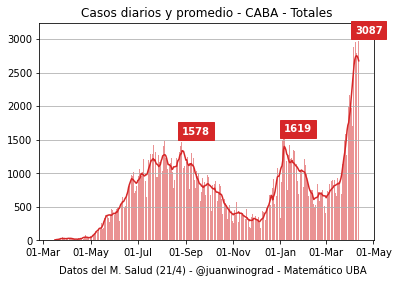

In [11]:
firma = "Datos del M. Salud (21/4) - @juanwinograd - Matemático UBA"
colores = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

fig, ax = plt.subplots(1)

color = colores[-1]
plt.bar(dias,casos_diarios_totales,color=color,alpha=0.5)
ax.plot(dias,casos_dia_prom_totales,label="Crecimiento promedio",color = color)
for x,y in maximos:
    plt.text(dias[x],y,y,backgroundcolor=color, color="white",fontweight="bold")
#plt.text(dias[-1],casos_dia_prom_totales[-1],round(casos_dia_prom_totales[-1],1),backgroundcolor=color, color="white",fontweight="bold")

plt.title("Casos diarios y promedio - CABA - Totales")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid(axis='y')
f = plt.text(dias[5],-500, firma)
plt.savefig("casos diarios totales.png",bbox_inches="tight")

Grafico edades escolares

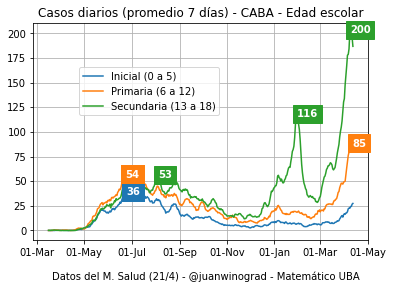

In [22]:
fig, ax = plt.subplots(1)

for i in range(len(niveles)-1):
	color= colores[i]
	ax.plot(dias,casos_dia_prom[i],label=list(niveles)[i]+ " ("+str(niveles[list(niveles)[i]][0])+" a "+str(niveles[list(niveles)[i]][1]-1)+")",color = color)
	for x,y in maximos_nivel[i]:
		plt.text(dias[x],y,round(y),backgroundcolor=color, color="white",fontweight="bold")


fig.legend(loc = (0.2,0.6))
plt.title("Casos diarios (promedio 7 días) - CABA - Edad escolar")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()
#locs, labels = plt.xticks(semanas)
f = plt.text(dias[5],-50, firma)
plt.savefig("casos diarios por nivel.png",bbox_inches="tight")

Calculo casos y ritmo de aumento por franja etaria por semana desde el incio de las clases presenciales

In [13]:
semanas = pd.date_range("20210215","20210415",freq="W-MON")

In [14]:
casos_nivel = []
aumento_nivel = []
for niv in niveles:
	casos_franja = []
	aumento_franja = []
	for semana in semanas:
		casos_franja.append(casos_entre(provincia,semana-pd.Timedelta("1 w"),semana,niveles[niv][0],niveles[niv][1]))
		aumento_franja.append((casos_franja[-1]/casos_franja[0]))
	casos_nivel.append(casos_franja)
	aumento_nivel.append(aumento_franja)

Grafico total de casos semanales por edades

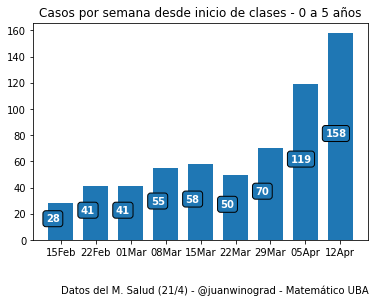

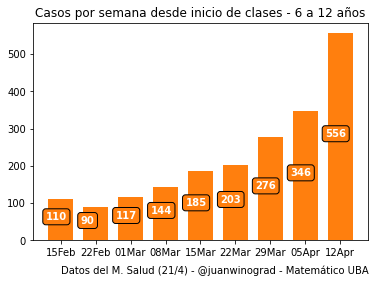

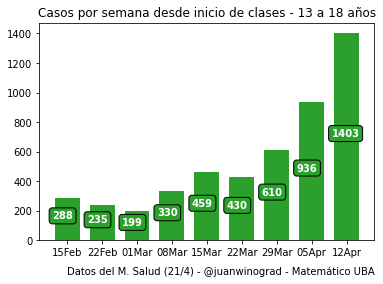

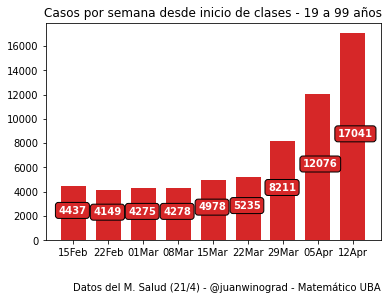

In [27]:
for j in range(len(niveles)):
    niv = niveles[list(niveles)[j]]

    fig, ax = plt.subplots(1)
    color = colores[j]
    plt.bar(semanas,casos_nivel[j],5,color=color)
    for i in range(len(semanas)):
        props = dict(boxstyle='round', facecolor=color)
        plt.text(semanas[i]-pd.Timedelta("3 d"),casos_nivel[j][i]/2,casos_nivel[j][i],color="white",fontweight="bold",bbox=props)

    plt.title("Casos por semana desde inicio de clases - "+str(niv[0])+" a "+str(niv[1]-1)+" años")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d%b'))
    locs, labels = plt.xticks(semanas)
    fig.patch.set_facecolor("white")
    f = plt.text(semanas[0],-casos_nivel[j][1], firma)
    plt.savefig(list(niveles)[j]+".png")

Aumento (por cuanto se multiplicaron) de los casos desde semana de inicio de clases

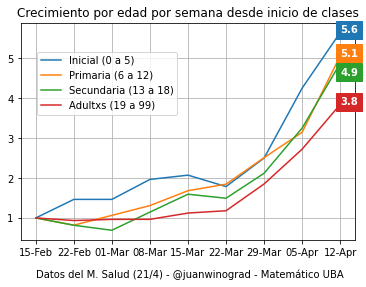

In [16]:
fig, ax = plt.subplots(1)

for i in range(len(niveles)):
	if i == 2:
		corrimiento = 0.3
	else:
		corrimiento = 0 
	color=next(ax._get_lines.prop_cycler)['color']
	ax.plot(semanas,aumento_nivel[i],label=list(niveles)[i]+ " ("+str(niveles[list(niveles)[i]][0])+" a "+str(niveles[list(niveles)[i]][1]-1)+")",color = color)
	plt.text(semanas[-1],aumento_nivel[i][-1]-corrimiento,round(aumento_nivel[i][-1],1),backgroundcolor=color, color="white",fontweight="bold")

fig.legend(loc = (0.1,0.6))
plt.title("Crecimiento por edad por semana desde inicio de clases")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()

locs, labels = plt.xticks(semanas)
fig.patch.set_facecolor("white")
f = plt.text(semanas[0],-0.5, firma)
plt.savefig("aumento por nivel.png",bbox_inches='tight')

Lo mismo que antes pero para todas las edades

In [17]:
faños = 10 # franjas de cuntos años
edades = [[a,a+faños] for a in range(0,100,faños)]

#Casos y aumento totales
casos_totales = []
aumento_totales = []
for semana in semanas:
	casos_totales.append(casos_entre(provincia,semana,semana+pd.Timedelta("1 w")))
	aumento_totales.append((casos_totales[-1]/casos_totales[0]))

#Casos y aumento por franja etaria
casos = []
aumento = []
for edad in edades:
	casos_franja = []
	aumento_franja = []
	for semana in semanas:
		casos_franja.append(casos_entre(provincia,semana,semana+pd.Timedelta("1 w"),edad[0],edad[1]))
		aumento_franja.append((casos_franja[-1]/casos_franja[0]))
	casos.append(casos_franja)
	aumento.append(aumento_franja)

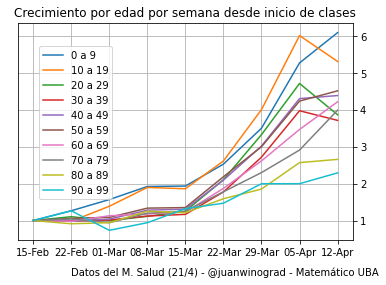

In [18]:
fig, ax = plt.subplots(1)

for i in range(len(edades)):
	color=next(ax._get_lines.prop_cycler)['color']
	ax.plot(semanas,aumento[i],label=str(edades[i][0])+" a "+str(edades[i][1]-1),color = color)


fig.legend(loc = (0.1,0.3))
plt.title("Crecimiento por edad por semana desde inicio de clases")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.yaxis.tick_right()
ax.grid()
locs, labels = plt.xticks(semanas)
fig.patch.set_facecolor("white")
f = plt.text(semanas[1],-0.5, firma)
plt.savefig("aumento por franja.png",bbox_inches='tight')

0 a 9 y 10 a 19 contra crecimiento promedio

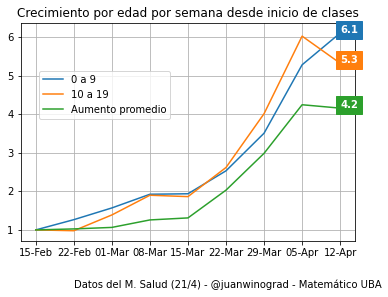

In [19]:
fig, ax = plt.subplots(1)

for i in range(2):
	color=next(ax._get_lines.prop_cycler)['color']
	ax.plot(semanas,aumento[i],label=str(edades[i][0])+" a "+str(edades[i][1]-1),color = color)
	plt.text(semanas[-1],aumento[i][-1],round(aumento[i][-1],1),backgroundcolor=color, color="white",fontweight="bold")

color=next(ax._get_lines.prop_cycler)['color']
ax.plot(semanas,aumento_totales,label="Aumento promedio",color = color)
plt.text(semanas[-1],aumento_totales[-1],round(aumento_totales[-1],1),backgroundcolor=color, color="white",fontweight="bold")

fig.legend(loc = (0.1,0.6))
plt.title("Crecimiento por edad por semana desde inicio de clases")

locs, labels = plt.xticks(semanas)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.grid()
fig.patch.set_facecolor("white")

f = plt.text(semanas[1],-0.5, firma)
plt.savefig("aumento por franja 2.png",bbox_inches='tight')